In [ ]:
import uuid

from IPython.display import Image, display
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

from langchain_openai import ChatOpenAI

# Define a new graph
workflow = StateGraph(state_schema=MessagesState)

# Define a chat model
# model = ChatOpenAI()
model = ChatOpenAI(
            openai_api_key="EMPTY",
            openai_api_base="http://localhost:8000/v1",
            model="K-intelligence/Midm-2.0-Base-Instruct",
        )


# Define the function that calls the model
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": response}


# Define the two nodes we will cycle between
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)


# Adding memory is straight forward in langgraph!
memory = MemorySaver()

app = workflow.compile(
    checkpointer=memory
)


# The thread id is a unique key that identifies
# this particular conversation.
# We'll just generate a random uuid here.
# This enables a single application to manage conversations among multiple users.
thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}


input_message = HumanMessage(content="hi! I'm bob")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

# Here, let's confirm that the AI remembers our name!
input_message = HumanMessage(content="what was my name?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

# -------------------------------

In [ ]:
from typing import Literal, Annotated
from langgraph.graph import MessagesState

class GraphState(MessagesState):
    task: Annotated[str, "사용자의 원요청(정규화된 태스크)"]
    slots: Annotated[dict, "슬롯/파라미터 (ex. 위치, 시간, 반경, 위험종류 등)"]
    selected_agent: Annotated[Literal["guideline_from_docs_rag", "realtime_status_api", "facility_finder_sql", None], "현재 선택된 에이전트 (None → supervisor가 결정)"]
    artifacts: Annotated[dict, {"guideline_from_docs_rag": {...}, "realtime_status_api": {...}, "facility_finder_sql": {...}}, "각 에이전트 산출물 (근거 포함)"]
    meta: Annotated[dict, "실행 메타 (재시도 카운트, 타임아웃, 비용 등)"]
    error: Annotated[str | None, "에러/경고 메시지 (노드가 실패 시 기록)"]

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    openai_api_key="EMPTY",
    openai_api_base="http://localhost:8000/v1",
    model="K-intelligence/Midm-2.0-Base-Instruct",
)

In [ ]:
from pydantic import BaseModel, Field

class Route(BaseModel):
    """슈퍼바이저의 라우팅 결과.

    - next: 지금 즉시 실행할 단일 에이전트 {"guideline_from_docs_rag", "realtime_status_api", "facility_finder_sql", "FINISH"} (완료 시 "FINISH").
    - reason: 선택 근거(한두 문장).
    - plan: 선택적 후속 단계 목록(예: ["realtime_status_api","facility_finder_sql"]; 즉시 실행 아님).
    """
    next: Literal["guideline_from_docs_rag", "realtime_status_api", "facility_finder_sql", "FINISH"] = Field(..., description="다음 실행 대상")
    reason: str = Field(..., description="선택 근거")
    plan: list[str] | None = Field(default=None, description="선택적 세부 실행 단계")

In [2]:
from langchain.tools import tool

@tool
def retrieve(query: str) -> list[str]:
    """
    재난 대응 관련 문서를 검색하는 도구.
    사용자 질문(query)에 따라 관련성이 높은 문서 3개를 반환한다.
    각 문서는 재난 대응 지침이나 절차를 담은 텍스트 조각(string) 형태로 제공된다.
    """
    return [
        "태풍 특보가 발령될 경우, 주민들은 가급적 외출을 자제하고 특히 해안가, 하천변, 그리고 공사장 주변과 같이 구조적으로 취약하거나 급작스러운 사고 위험이 높은 지역으로의 접근을 삼가야 한다는 지침이 반복적으로 강조되고 있다.",
        "주택이나 건물의 안전을 확보하기 위해서는 사전에 창문 틈새를 보강하는 작업을 실시하고, 또한 빗물이 원활히 빠져나갈 수 있도록 배수구와 집수정에 낙엽이나 쓰레기 등 이물질이 막혀 있는지 여부를 반드시 점검해야 한다. 이러한 예방 조치는 홍수 피해를 줄이는 데 큰 역할을 한다.",
        "정전 사태에 대비하기 위해서는 가정마다 손전등과 보조배터리를 비치하는 것이 필요하며, 만약 장시간 통신이 두절될 가능성에 대비해 휴대용 라디오를 준비해 두면 재난 방송이나 긴급 안내를 신속히 확인할 수 있어 대응 능력이 크게 향상된다.",
    ]

@tool
def generate(query: str, contexts: list[str]) -> str:
    """
    재난 대응책을 생성하는 도구.

    입력:
        - query (str): 사용자가 질문한 원문.
        - contexts (list[str]): retrieve 도구에서 검색된 관련 문서들의 리스트.

    동작:
        주어진 query와 contexts를 종합적으로 고려하여
        질문에 적합한 대응책(answer)을 작성한다.

    출력:
        - answer (str): 재난 상황에 대한 대응책을 자연어로 생성한다.
    """
    return (
        "## 대응책\n\n"
        "### 핵심 요약\n"
        "태풍 상황에서는 주민 안전이 최우선입니다. "
        "지자체 공지와 기존 지침을 종합해, 외출을 자제하고 "
        "사전에 시설물 안전 점검 및 필수 비상 용품을 준비해야 합니다.\n\n"

        "### 단계별 지침\n"
        "1. 주민 안전을 최우선으로 확보한다.\n"
        "2. 비상 연락망을 활용해 상황을 공유한다.\n"
        "3. 창문·배수구·옥외 시설물 등 구조물을 사전에 점검한다.\n"
        "4. 정전 및 통신 두절에 대비해 손전등·보조배터리·라디오를 준비한다.\n"
        "5. 필요 시 지자체 안내에 따라 대피하거나 차량 이동을 조정한다.\n\n"
    )

@tool
def local_notice(query: str) -> list[str]:
    """
    지자체에서 발송한 재난 관련 공지사항을 검색하는 도구.
    사용자 질문(query)에 따라 관련성이 높은 공지 텍스트 조각(string) 3개를 반환한다.
    """
    return [
        "○○시 재난안전대책본부에서는 금일 오후부터 내일까지 집중 호우가 예보됨에 따라 저지대 주택가 주민들께서는 미리 귀중품을 안전한 장소로 이동시키고, 또한 주차된 차량을 침수 위험이 낮은 지역으로 옮겨 두시기를 안내드립니다.",
        "본 관할 구청은 태풍 북상에 따른 강풍 피해를 최소화하기 위해 공공시설물 안전 점검을 긴급 실시하고 있으며, 주민 여러분께서는 옥외 간판, 창문, 화분 등 바람에 날릴 수 있는 물건들을 사전에 고정하여 주시기를 요청드립니다. 이와 관련된... ",
        "주민 여러분께서는 기상 특보 발효 시 불필요한 외출을 자제하시고, 특히 하천 산책로나 교량 인근 접근은 통제될 수 있음을 알려드립니다. 아울러 대중교통 운행이 제한될 가능성이 있어 사전에 이동 계획을 조정하시기를 바랍니다.",
    ]


In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage

# llm = ChatOpenAI(model="gpt-5-nano")
llm = ChatOpenAI(
            openai_api_key="EMPTY",
            openai_api_base="http://localhost:8000/v1",
            model="K-intelligence/Midm-2.0-Base-Instruct",
        )
# llm = ChatOpenAI(
#     openai_api_key="EMPTY",
#     openai_api_base="http://localhost:8000/v1",
#     model="skt/A.X-4.0-Light",
# )

tools = [retrieve, generate, local_notice]

AGENT_PROMPT = """너는 재난 대응 지침을 작성하는 에이전트다.  
retrieve도구를 사용할 경우 반드시 generate도 사용해야 한다.
너의 출력은 반드시 JSON 형식이어야 한다.

허용되는 출력은 두 가지 중 하나다:
1) {"action": "<tool_name>", "args": {...}}
2) {"answer": "<최종 답변>"}

그 외의 어떤 설명, 질문, 되묻기, 친절한 문장도 금지한다.

"""
agent = create_react_agent(llm, tools, prompt=AGENT_PROMPT)

inputs = {"messages": [HumanMessage(content="지금 태풍이 오고있다. 대응 방법을 알려줘")]}
output = agent.invoke(inputs)

print(output)

{'messages': [HumanMessage(content='지금 태풍이 오고있다. 대응 방법을 알려줘', additional_kwargs={}, response_metadata={}, id='f9457a08-a9f1-4775-a141-6bfc9de4369e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-a056f97703cf4da7977812be32f8fcb0', 'function': {'arguments': '{"query": "태풍 대응 방법 재난 대응 지침"}', 'name': 'retrieve'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 1070, 'total_tokens': 1099, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'K-intelligence/Midm-2.0-Base-Instruct', 'system_fingerprint': None, 'id': 'chatcmpl-8e9f6116eb96467bb4716e25237621c7', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--86da392b-1558-4158-861a-a75c75afb096-0', tool_calls=[{'name': 'retrieve', 'args': {'query': '태풍 대응 방법 재난 대응 지침'}, 'id': 'chatcmpl-tool-a056f97703cf4da7977812be32f8fcb0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1070

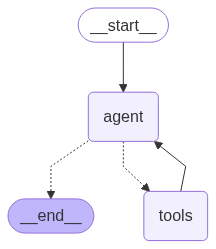

In [3]:
from IPython.display import Image

display(Image(agent.get_graph().draw_mermaid_png()))

In [1]:
from langchain.tools import tool
import time

@tool
def weather_status(location: str) -> dict:
    """
    특정 지역(location)의 현재 기상 상황을 조회하는 도구.
    반환 예시:
        {
          "location": "서울 서초구",
          "status": "강한 비",
          "temperature": 24.5,
          "wind_speed": "10m/s",
          "alert": "호우주의보 발효 중"
        }
    """ 
    return {
        "location": location,
        "status": "강한 비",
        "temperature": 24.5,
        "wind_speed": "10m/s",
        "alert": "호우주의보 발효 중"
    }

@tool
def disaster_alerts(location: str) -> list[str]:
    """
    특정 지역(location)의 실시간 재난 경보 / 알림 정보를 조회하는 도구.
    """
    return [
        f"{location}에 현재 호우주의보가 발효 중입니다.",
        f"{location} 하천변 접근을 자제하시고, 대중교통 운행에 차질이 있을 수 있습니다.",
        f"{location} 일부 저지대 주차장 및 도로에 침수 가능성이 있습니다."
    ]

@tool
def traffic_status(location: str) -> list[str]:
    """
    특정 지역(location)의 교통 및 도로 상황을 조회하는 도구.
    """
    return [
        f"{location} 반포대로 일대 침수로 차량 통제 중.",
        f"{location} 강남대로 일부 버스노선 우회 운행.",
        f"{location} 경부고속도로 서울 방향 일부 구간 서행 발생."
    ]


In [2]:
from pydantic import BaseModel

class WeatherStatus(BaseModel):
    location: str
    status: str
    temperature: float
    wind_speed: str
    alert: str


class DisasterAlerts(BaseModel):
    location: str
    alerts: list[str]


class TrafficStatus(BaseModel):
    location: str
    traffic: list[str]

class EmergencyStatus(BaseModel):
    """
    특정 지역(location)의 종합적인 상황(날씨, 재난, 교통)을 담는 모델
    """
    weather: WeatherStatus
    disaster: DisasterAlerts
    traffic: TrafficStatus

In [15]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_google_genai import ChatGoogleGenerativeAI

REALTIME_PROMPT = """너는 실시간 재난 정보 호출 에이전트다.
특별한 요구가 없다면 다음 3가지 정보를 모두 제공한다. 
  1) 기상 상황 (예: 현재 날씨, 기온, 강수 여부)  
  2) 재난 경보 (예: 호우경보, 지진, 대설, 화재 등)  
  3) 도로/교통 상황 (예: 주요 도로 혼잡, 통제 구간)

규칙:  
- 사용자의 질문에 대해 되묻지 말고, 즉시 필요한 도구를 호출하거나 정보를 제공한다.
- 도구가 한번만 호출 되었다면 같은 도구를 두번 호출하라
"""

# llm = ChatOpenAI(
#     openai_api_key="EMPTY",
#     openai_api_base="http://localhost:8000/v1",
#     model="skt/A.X-4.0-Light",
# )
# llm = ChatOpenAI(model="gpt-5-nano")
# llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
llm = ChatOpenAI(
    openai_api_key="EMPTY",
    openai_api_base="http://localhost:8000/v1",
    model="K-intelligence/Midm-2.0-Base-Instruct",
)
# llm = ChatOpenAI(
#     openai_api_key="EMPTY",
#     openai_api_base="http://localhost:8000/v1",
#     model="meta-llama/Llama-3.1-8B-Instruct",
#     parallel_tool_calls=False
# )

realtime_tools = [weather_status, disaster_alerts, traffic_status]

realtime_agent = create_react_agent(llm, realtime_tools, prompt=REALTIME_PROMPT, response_format=EmergencyStatus)

# 실행 예시
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="서초구의 기상 상황, 재난 경보, 도로/교통 상황 호출")]}
output = realtime_agent.invoke(inputs)
print(output)


{'messages': [HumanMessage(content='서초구의 기상 상황, 재난 경보, 도로/교통 상황 호출', additional_kwargs={}, response_metadata={}, id='01e443ac-6d4b-4f89-bf0b-10a1b2da74b0'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-46c4bf43008a41a081daabda6dd201ca', 'function': {'arguments': '{"location": "서초구"}', 'name': 'weather_status'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 1025, 'total_tokens': 1050, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'K-intelligence/Midm-2.0-Base-Instruct', 'system_fingerprint': None, 'id': 'chatcmpl-9bbbfffa36e94688aae356cf86bbc4ec', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2fb5cc42-f7c9-45da-84b8-ecc83500ce9d-0', tool_calls=[{'name': 'weather_status', 'args': {'location': '서초구'}, 'id': 'chatcmpl-tool-46c4bf43008a41a081daabda6dd201ca', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1025, '